# Training Notebook

# RSNA 2023 Abdominal Trauma Detection with [KerasCV](https://github.com/keras-team/keras-cv) and [KerasCore](https://github.com/keras-team/keras-core)

This notebook walks you through how to train a **Convolutional Neural Network (CNN)** model using Keras (Core and CV) on the RSNA 2023 Abdominal Trauma Detection dataset made available for this competition.

Fun fact: This notebook is backend (tensorflow, pytorch, jax) agnostic. Using KerasCV and KerasCore we can choose a backend of our choise! Feel free to read [Keras Core](https://keras.io/keras_core/announcement/) announcement to know more about Keras.

In this notebook you will learn:

* Loading the data using [`tf.data`](https://www.tensorflow.org/guide/data).
* Applying augmentations inside the data pipeline.
* Create the model using KerasCV presets.
* Train the model.
* Visualize the training plots.

## Notebooks

For this competition we have two starter notebook. This notebook (you are reading) trains the model on the dataset, while there lies another notebook that performs inference and submits to the competition.

1. [**Training Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train)
2. [**Inference Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer)

**Note**: [KerasCV guides](https://keras.io/guides/keras_cv/) is the place to go for a deeper understanding of KerasCV individually.

# Setup and Imports

We will need KerasCV for this notebook.


In [2]:
! pip install --upgrade pip
! pip install keras-cv
! pip install seaborn
! pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
  Obtaining dependency information for keras-cv from https://files.pythonhosted.org/packages/be/4c/a45de94dcaa533bdf1dce1643321d57452c79e7b581c9d573facf10c7118/keras_cv-0.6.4-py3-none-any.whl.metadata
  Obtaining dependency information for regex from https://files.pythonhosted.org/packages/79/33/67c4ed826f5227655225c3feaaecd15afb8453e827334ddae95a7fba07ac/regex-2023.10.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.7 MB/s eta 0:00:00
  Obtaining dependency information for keras-core from https://files.pythonhosted.org/packages/33/18/5280fbfd70485fae8088a2f44647ea0d82c7dc9b80635ae2e7c578f785e0/keras_core-0.1.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization

# Utils
import gc

# plots
from matplotlib import pyplot as plt
import seaborn as sns

# aws
import boto3


D1014 10:16:32.186262442      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1014 10:16:32.186293618      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1014 10:16:32.186297367      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1014 10:16:32.186300290      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1014 10:16:32.186302693      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1014 10:16:32.186308647      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1014 10:16:32.186311344      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1014 10:16:32.

Using TensorFlow backend


/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

A particularly good practise is to have a configuration class for your notebooks. This not only keeps your configurations all at a single place but also becomes handy to map the configs to the performance of the model.

Please play around with the configurations and see how the performance of the model changes.

In [4]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE
    STRIDE = 10

config = Config()

# Reproducibility

We would want this notebook to have reproducible results. Here we set the seed for all the random algorithms so that we can reproduce the experiments each time exactly the same way.

In [5]:
keras.utils.set_random_seed(seed=config.SEED)

# Exploratory Data Analysis (EDA)

# Dataset

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

[A helpful resource on the conversion of DICOM to PNG](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs)

In [6]:
BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-v2-dataset"

## Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [7]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


In [8]:
# Checking the summary statistics of the dataset
summary_statistics = dataframe.describe()

summary_statistics.iloc[1]

patient_id               34909.677862
bowel_healthy                0.478760
bowel_injury                 0.521240
extravasation_healthy        0.303350
extravasation_injury         0.696650
kidney_healthy               0.870729
kidney_low                   0.076316
kidney_high                  0.052955
liver_healthy                0.812703
liver_low                    0.159864
liver_high                   0.027434
spleen_healthy               0.679192
spleen_low                   0.150220
spleen_high                  0.170588
any_injury                   1.000000
series_id                31188.356056
instance_number            311.704132
width                      512.733062
height                     511.981046
Name: mean, dtype: float64

In [9]:
# Checking for missing values
missing_values = dataframe.isnull().sum()

missing_values

patient_id               0
bowel_healthy            0
bowel_injury             0
extravasation_healthy    0
extravasation_injury     0
kidney_healthy           0
kidney_low               0
kidney_high              0
liver_healthy            0
liver_low                0
liver_high               0
spleen_healthy           0
spleen_low               0
spleen_high              0
any_injury               0
series_id                0
instance_number          0
injury_name              0
image_path               0
width                    0
height                   0
dtype: int64

No missing values makes it easier for us!

In [10]:
del missing_values
del summary_statistics
gc.collect()

0

## Class Dependency

We will explore the difference between health columns vs. injury columns

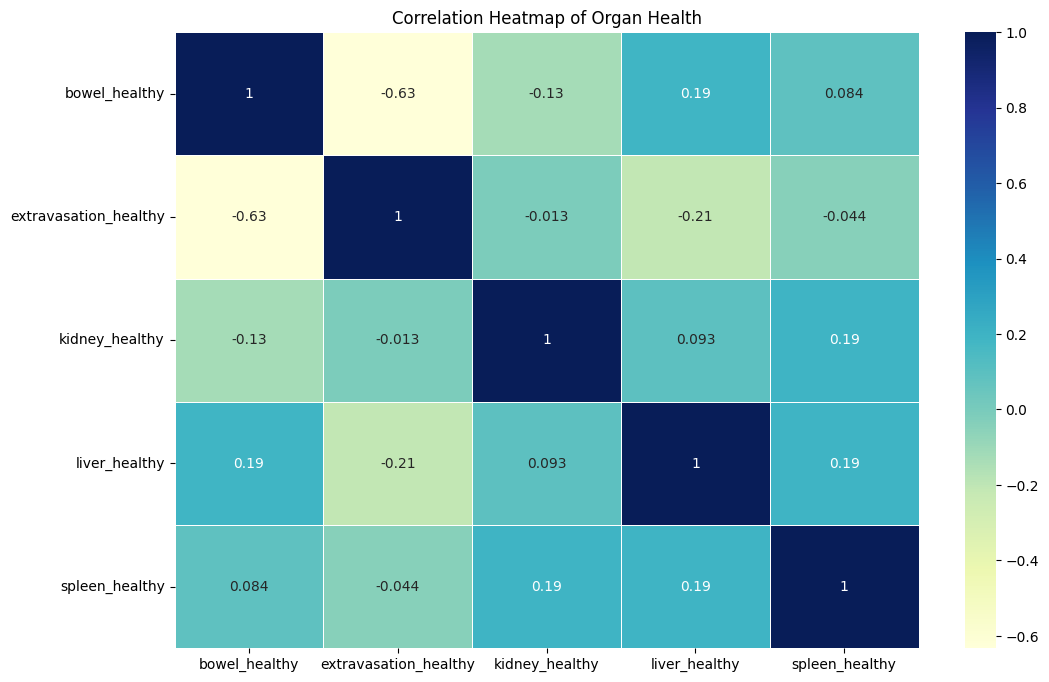

In [11]:
# Selecting columns related to the health of organs
health_columns = [
    "bowel_healthy", "extravasation_healthy", "kidney_healthy", 
    "liver_healthy", "spleen_healthy",
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = dataframe[health_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Health")
plt.show()

The correlations between different health columns are generally small, indicating that the healthy state of one organ might not be strongly related to the healthy state of other organs.

There is no strong correlation between any two specific health-related columns, suggesting that the health status of different organs is relatively independent of each other.

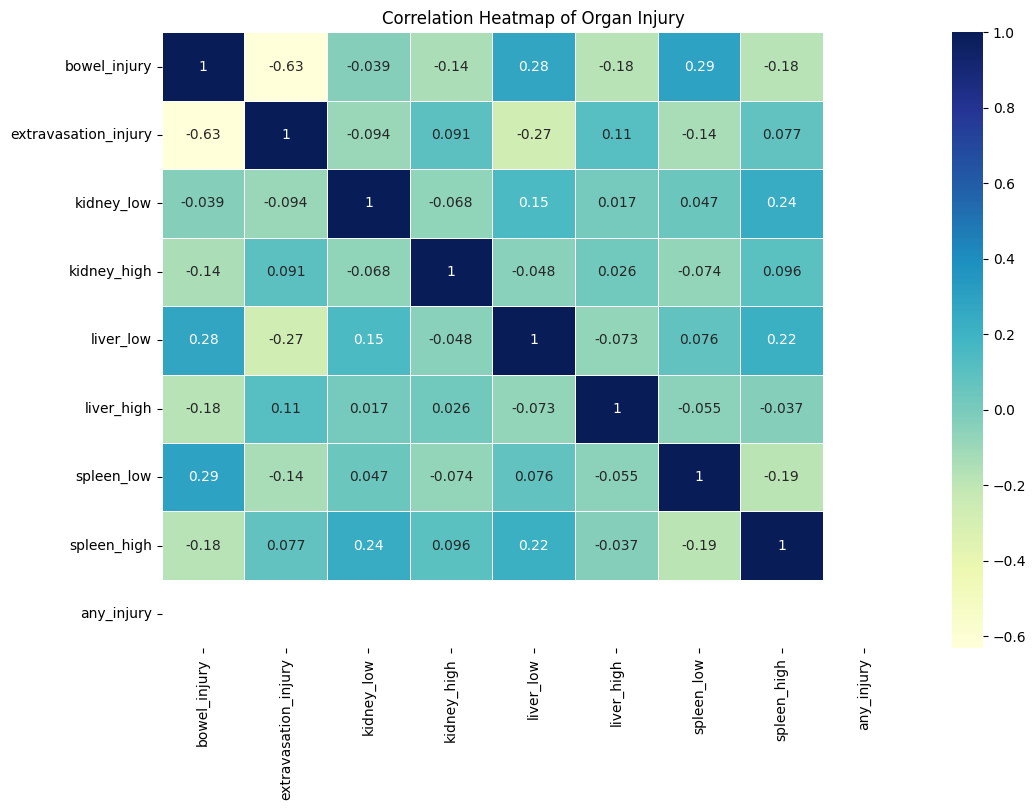

In [12]:
# Selecting columns related to the health of organs
injury_columns = [
    "bowel_injury", "extravasation_injury",
    "kidney_low", "kidney_high", 
    "liver_low", "liver_high",
    "spleen_low", "spleen_high",
    "any_injury"
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = dataframe[injury_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Injury")
plt.show()

### Bowel and Extravasation:

* `bowel_injury`: This shows a moderate correlation with `any_injury` (0.24) and a smaller correlation with `extravasation_injury` (0.13)
* `extravasation_injury`: This has a strong correlation with `any_injury` (0.43) and a moderate correlation with `spleen_high` (0.200).

### Kidney:

* `kidney_low`: This is moderately correlated with `ny_injury` (0.319).
* `kidney_high`: Similar to kidney_low, this is moderately correlated with `any_injury` (0.24).

### Liver:

* `liver_low`: This has a strong correlation with `any_injury` (0.490).
* `liver_high`: This shows a moderate correlation with `any_injury` (0.232).

### Spleen:

* `spleen_low`: This is moderately correlated with `any_injury` (0.425).
* `spleen_high`: This shows a moderate correlation with `any_injury` (0.373) and `extravasation_injury` (0.200).

### Conclusions: 

**The `any_injury` column is moderately to strongly correlated with all other injury columns, suggesting that it may be a summary measure of injury presence across different organs.**

There are some specific correlations between individual injury types, such as the correlation between `extravasation_injury` and `spleen_high`.

The correlations between the low and high levels of organ injuries (e.g., `kidney_low` and `kidney_high`) are generally lower, indicating that these might be independent conditions.

The correlation between different organs' injuries is generally low, which might suggest that injuries to different organs occur independently of each other.

## Note on some observations

1. Class Dependencies: Refers to inherent relationships between classes in the analysis.
2. Complementarity: `bowel_injury` and `bowel_healthy`, as well as `extravasation_injury` and `extravasation_healthy`, are perfectly complementary, with their sum always equal to 1.0.
3. Simplification: For the model, only `{bowel/extravasation}_injury` will be included, and the corresponding healthy status can be calculated using a sigmoid function.
4. Softmax: `{kidney/liver/spleen}_{healthy/low/high}` classifications are softmaxed, ensuring their combined probabilities sum up to 1.0 for each organ, simplifying the model while preserving essential information.

In [13]:
del correlation_matrix
gc.collect()

17603

# Data Wrangling

We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [14]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [15]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

## Data Pipeline /w tf.data

Here we build the data pipeline using `tf.data`. Using `tf.data` we can map out data to an augmentation pipeline simple by using the ` map` API.

Adding augmentations to the data pipeline is as simple as adding a layer into the list of layers that the `Augmenter` processes.

Reference: https://keras.io/api/keras_cv/layers/augmentation/

In [16]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            
        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [17]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

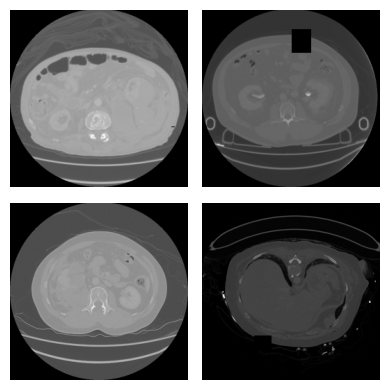

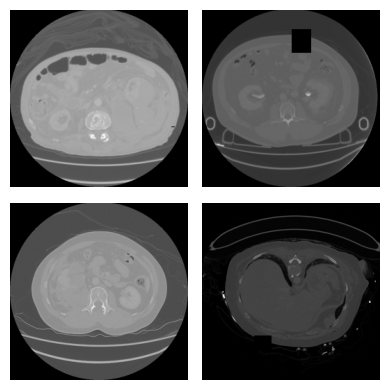

In [18]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

# Build Model

We are going to load a pretrained model from the [list of avaiable backbones in KerasCV](https://keras.io/api/keras_cv/models/backbones/). We are using the `ResNetBackbone` as our backbone. The practise of using a pretrained model and finetuning it to a specific dataset is prevalent in the DL community.

We use the [Functional API](https://keras.io/guides/functional_api/) of Keras to build the model. The design of the model would be such that we input a single image and we get different heads for the various predictions we need (kidney, spleen...).

We have also added a Learning Rate scheduler for you to work with. When an athlete trains, the first step is always to warm up. We take a similar approach to training our models. We warm up with model where the learning rate increses from the initial LR to a higher LR. After the warmup stage we provide a decay algorithm (cosine here). A list of all the learning rate scheduler can be found [here](https://keras.io/api/optimizers/learning_rate_schedules/).

In [19]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
    # Define Backbone
    backbone = keras_cv.models.ResNetV2Backbone.from_preset("resnet50_v2_imagenet")
    backbone.include_rescaling = False
    x = backbone(inputs)
    
    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        "extra":keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        "liver":keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        "kidney":keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        "spleen":keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )
    
    return model

# Modelling

In [20]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=96640
warmup_steps=9664
decay_steps=86976


### Visualising the learning rate scheduler

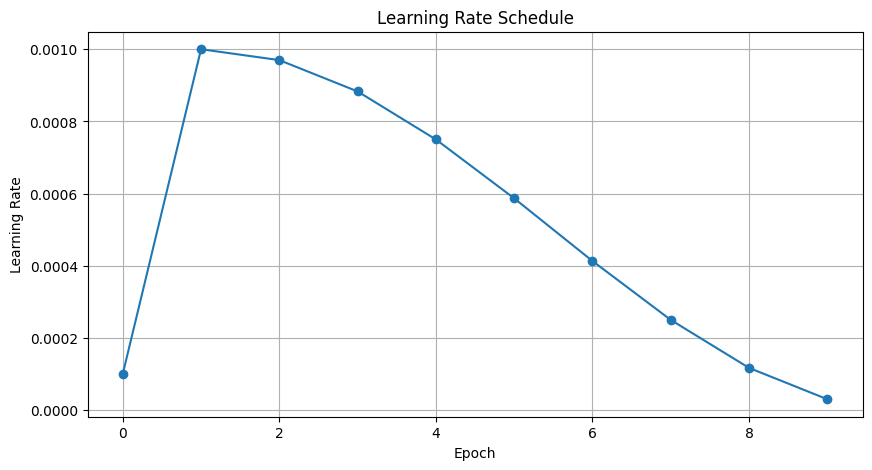

In [32]:
# visualise learning rate scheduler
def visualize_learning_rate(warmup_steps, decay_steps, initial_learning_rate=1e-4, alpha=0.0, epochs=config.EPOCHS):
    """
    Visualize the learning rate over epochs given specific cosine decay parameters.

    Parameters:
        - warmup_steps: int, number of steps for the warmup phase
        - decay_steps: int, number of steps to apply the decay function
        - initial_learning_rate: float, initial learning rate before decay
        - alpha: float, minimum learning rate value as a fraction of the initial_learning_rate
        - warmup_target: float, target warmup learning rate
        - epochs: int, number of epochs to visualize the learning rate for
    """
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=alpha,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    lrs = [cosine_decay(epoch*total_train_steps/epochs).numpy() for epoch in range(epochs)]

    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), lrs, marker='o')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

# Example usage
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps
visualize_learning_rate(warmup_steps, decay_steps, epochs=config.EPOCHS)


## Train the model with "model.fit"

In [22]:
# # build the model
# print("[INFO] Building the model...")
# model = build_model(warmup_steps, decay_steps)

# # train
# print("[INFO] Training...")
# history = model.fit(
#     train_ds,
#     epochs=config.EPOCHS,
#     validation_data=val_ds,
# )

We'll use TPU to speed up the training process, as we're working with tensorflow datasets.

In [23]:
import tensorflow as tf

# Initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)



Running on TPU 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [24]:
# Model Creation Inside Strategy Scope: 
with strategy.scope():
    # Your model creation code here, for example:
    model = build_model(warmup_steps, decay_steps)  # Assuming your function from the previous code
    
# Data: Ensure your data is in a TPU-friendly format.
# Example: If you're using tf.data.Dataset for your data, you should batch the data appropriately.

history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

94687928/94687928 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
Epoch 1/10


2023-10-14 10:18:29.319819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
2023-10-14 10:18:30.483322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - bowel_accuracy: 7.3036 - extra_accuracy: 7.0953 - kidney_accuracy: 6.1671 - liver_accuracy: 5.3905 - loss: 25.6454 - spleen_accuracy: 4.4105

2023-10-14 10:20:26.982453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
2023-10-14 10:20:27.327561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


151/151 ━━━━━━━━━━━━━━━━━━━━ 217s 579ms/step - bowel_accuracy: 7.2614 - extra_accuracy: 7.0537 - kidney_accuracy: 6.1320 - liver_accuracy: 5.3606 - loss: 25.4958 - spleen_accuracy: 4.3859 - val_bowel_accuracy: 0.4983 - val_extra_accuracy: 0.7129 - val_kidney_accuracy: 0.8185 - val_liver_accuracy: 0.8647 - val_loss: 4.2672 - val_spleen_accuracy: 0.6964
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - bowel_accuracy: 3.5837 - extra_accuracy: 6.7476 - kidney_accuracy: 6.2879 - liver_accuracy: 5.6169 - loss: 35.3476 - spleen_accuracy: 4.8528 - val_bowel_accuracy: 0.5017 - val_extra_accuracy: 0.2706 - val_kidney_accuracy: 0.8284 - val_liver_accuracy: 0.8845 - val_loss: 3.9172 - val_spleen_accuracy: 0.6568
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - bowel_accuracy: 3.2170 - extra_accuracy: 6.7844 - kidney_accuracy: 6.2813 - liver_accuracy: 5.6027 - loss: 33.8250 - spleen_accuracy: 4.8647 - val_bowel_accuracy: 0.5116 - val_extra_accuracy: 0.6964 - val_kidney_accuracy: 0.7

## Visualize the training plots

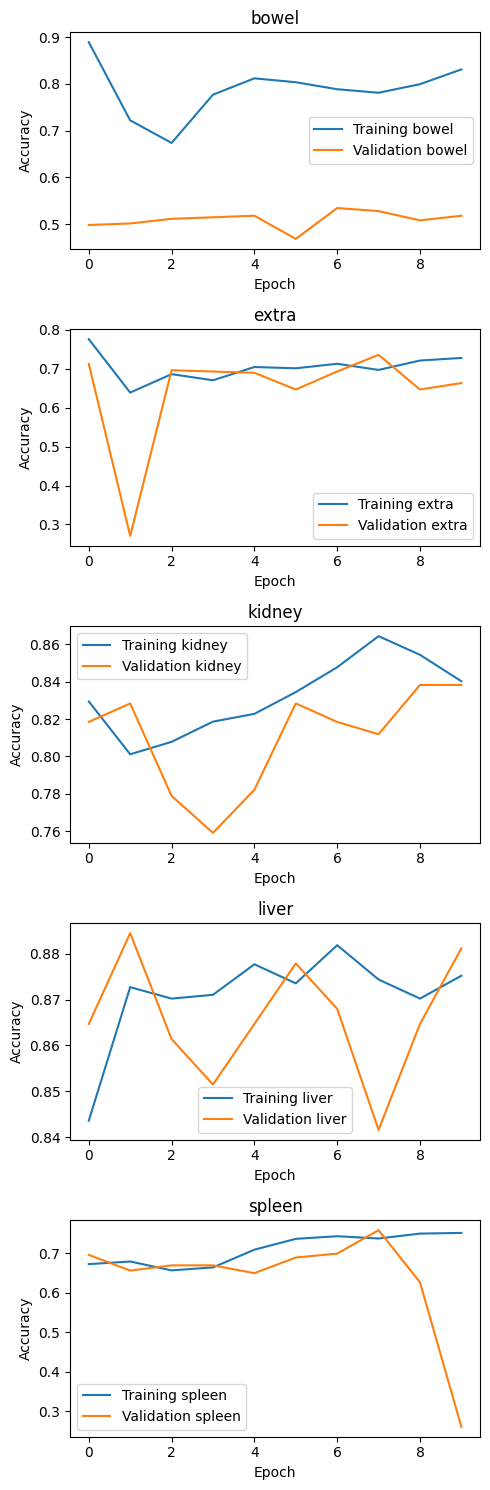

In [25]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

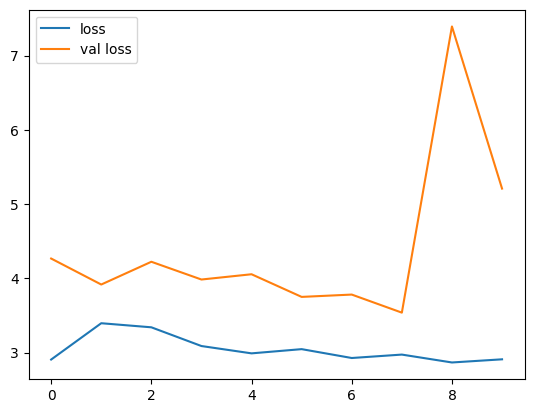

In [26]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

The visualisations suggest that our model is overfitting, as the validation loss increased with increasing training epochs, while the training loss decreases. To resolve this issue, we can add regularisation techniques. There are several techniques:
1. Add dropout layers in the model.
2. Use BatchNormalization
3. Add L2 / L1 regularisation
4. Use early stopping
5. Data Augmentation, which we already did.

We experiment with adding dropout layers and batch normalization layers.

In [27]:
# del val_data
# del train_data
# gc.collect()

In [28]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
    # Define Backbone
    backbone = keras_cv.models.ResNetV2Backbone.from_preset("resnet50_v2_imagenet")
    backbone.include_rescaling = False
    x = backbone(inputs)
    
    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32)(x)
    x_bowel = keras.layers.BatchNormalization()(x_bowel)
    
    x_extra = keras.layers.Dense(32)(x)
    x_extra = keras.layers.BatchNormalization()(x_extra)
    
    x_liver = keras.layers.Dense(32)(x)
    x_liver = keras.layers.BatchNormalization()(x_liver)
    
    x_kidney = keras.layers.Dense(32)(x)
    x_kidney = keras.layers.BatchNormalization()(x_kidney)
    
    x_spleen = keras.layers.Dense(32)(x)
    x_spleen = keras.layers.BatchNormalization()(x_spleen)
    
    # Add Activation layers
    x_bowel = keras.layers.Activation('silu')(x_bowel)
    x_extra = keras.layers.Activation('silu')(x_extra)
    x_liver = keras.layers.Activation('silu')(x_liver)
    x_kidney = keras.layers.Activation('silu')(x_kidney)
    x_spleen = keras.layers.Activation('silu')(x_spleen)
    
    # Add dropout layers to reduce overfitting
    dropout_rate = 0.3
    x_bowel = keras.layers.Dropout(rate=dropout_rate)(x_bowel)
    x_extra = keras.layers.Dropout(rate=dropout_rate)(x_extra)
    x_liver = keras.layers.Dropout(rate=dropout_rate)(x_liver)
    x_kidney = keras.layers.Dropout(rate=dropout_rate)(x_kidney)
    x_spleen = keras.layers.Dropout(rate=dropout_rate)(x_spleen)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        "extra":keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        "liver":keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        "kidney":keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        "spleen":keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )
    
    return model

We'll also use early stopping to prevent overfitting.

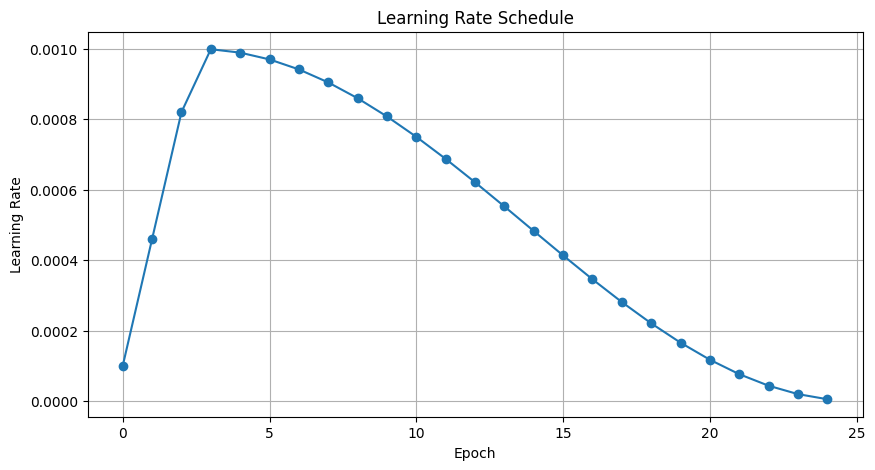

In [33]:
total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * (config.EPOCHS+15)
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

visualize_learning_rate(warmup_steps, decay_steps, epochs=config.EPOCHS+15)

In [35]:
total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * (config.EPOCHS+15)
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

# Model Creation Inside Strategy Scope: 
with strategy.scope():
    # Your model creation code here, for example:
    model = build_model(warmup_steps, decay_steps)  # Assuming your function from the previous code
    
# Data: Ensure your data is in a TPU-friendly format.
# Example: If you're using tf.data.Dataset for your data, you should batch the data appropriately.

history = model.fit(
    train_ds,
    epochs=config.EPOCHS+15,
    validation_data=val_ds,
)

[INFO] Building the model...
[INFO] Compiling the model...
Epoch 1/25


2023-10-14 10:32:24.485795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
2023-10-14 10:32:25.830664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - bowel_accuracy: 4.7467 - extra_accuracy: 3.9296 - kidney_accuracy: 3.1154 - liver_accuracy: 2.6670 - loss: 42.1400 - spleen_accuracy: 2.8453

2023-10-14 10:34:25.896129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
2023-10-14 10:34:26.253342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


151/151 ━━━━━━━━━━━━━━━━━━━━ 230s 596ms/step - bowel_accuracy: 4.7189 - extra_accuracy: 3.9072 - kidney_accuracy: 3.0976 - liver_accuracy: 2.6515 - loss: 41.8969 - spleen_accuracy: 2.8292 - val_bowel_accuracy: 0.5083 - val_extra_accuracy: 0.4719 - val_kidney_accuracy: 0.1716 - val_liver_accuracy: 0.0495 - val_loss: 4.8675 - val_spleen_accuracy: 0.1947
Epoch 2/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - bowel_accuracy: 4.7629 - extra_accuracy: 4.2268 - kidney_accuracy: 3.8310 - liver_accuracy: 3.4922 - loss: 37.5863 - spleen_accuracy: 3.7438 - val_bowel_accuracy: 0.5116 - val_extra_accuracy: 0.7030 - val_kidney_accuracy: 0.0330 - val_liver_accuracy: 0.8449 - val_loss: 4.7376 - val_spleen_accuracy: 0.6535
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 35s 186ms/step - bowel_accuracy: 4.6664 - extra_accuracy: 4.4766 - kidney_accuracy: 4.4642 - liver_accuracy: 4.0435 - loss: 35.1904 - spleen_accuracy: 4.0317 - val_bowel_accuracy: 0.5347 - val_extra_accuracy: 0.6733 - val_kidney_accuracy: 0.0

Write a function to plot the ROC-AUC curve and Precision-recall curve

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import gc
# from tqdm import tqdm
# from sklearn.metrics import roc_curve, auc, precision_recall_curve


# def get_predictions_and_labels_for_test(test_df, model):å
#     patient_ids = test_df["patient_id"].unique()
#     patient_preds = np.zeros(shape=(len(patient_ids), 2*2 + 3*3), dtype="float32")
#     actual_labels = []
    
#     for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
#         patient_df = test_df.query("patient_id == @patient_id")
#         actual_labels.extend(patient_df['label'].values)
#         patient_paths = patient_df.image_path.tolist()
        
#         dtest = build_dataset(patient_paths)
#         pred = model.predict(dtest)
#         pred = np.concatenate(pred, axis=-1).astype("float32")
#         pred = np.mean(pred.reshape(1, len(patient_paths), 11), axis=0)
#         pred = np.max(pred, axis=0, keepdims=True)
        
#         patient_preds[pidx, :] += post_proc(pred)[0]
#         del patient_df, patient_paths, dtest, pred
#         gc.collect()
        
#     return patient_preds, np.array(actual_labels)

# # Define a function for post-processing predictions
# def post_proc(predictions):
#     proc_pred = np.empty((predictions.shape[0], 2*2 + 3*3), dtype="float32")

#     # bowel, extravasation
#     proc_pred[:, 0] = predictions[:, 0]
#     proc_pred[:, 1] = 1 - proc_pred[:, 0]
#     proc_pred[:, 2] = predictions[:, 1]
#     proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
#     # liver, kidney, spleen
#     proc_pred[:, 4:7] = predictions[:, 2:5]
#     proc_pred[:, 7:10] = predictions[:, 5:8]
#     proc_pred[:, 10:13] = predictions[:, 8:11]

#     return proc_pred

# # Define a function to plot ROC or Precision-Recall curves, training, and validation plots
# def plot_curves(history, config, data, model, curve_type="roc", plot_accuracy=True):
# # Create a 5x2 grid for the subplots
# fig, axes = plt.subplots(5, 2, figsize=(10, 15))  # Change to 5x2 grid

# # Iterate through the metrics and plot them
# for i, metric_name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
#     # Plot training accuracy
#     if plot_accuracy:
#         training_acc_key = f'{metric_name}_accuracy'
#         validation_acc_key = f'val_{metric_name}_accuracy'
        
#         # Use axes to plot instead of creating new subplot
#         ax = axes[i, 0]  # Use first column for accuracy
#         ax.plot(history.history[training_acc_key], label='Training ' + metric_name)
#         ax.plot(history.history[validation_acc_key], label='Validation ' + metric_name)
#         ax.set_title(metric_name + ' Accuracy')
#         ax.set_xlabel('Epoch')
#         ax.set_ylabel('Accuracy')
#         ax.legend()
#         ax.grid(True)  # Add gridlines for better readability
        
#         # If you also have loss data, plot it in the second column
#         training_loss_key = f'{metric_name}_loss'
#         validation_loss_key = f'val_{metric_name}_loss'
        
#         ax = axes[i, 1]  # Use second column for loss
#         ax.plot(history.history[training_loss_key], label='Training ' + metric_name)
#         ax.plot(history.history[validation_loss_key], label='Validation ' + metric_name)
#         ax.set_title(metric_name + ' Loss')
#         ax.set_xlabel('Epoch')
#         ax.set_ylabel('Loss')
#         ax.legend()
#         ax.grid(True)  # Add gridlines for better readability

#     plt.tight_layout()

    
#     # Getting unique patient IDs from test dataset
#     predicted_labels, actual_labels = get_predictions_and_labels_for_test(data, model)
    
#     for i, metric_name in enumerate(config.TARGET_COLS):
#         plt.figure(figsize=(10, 7))
        
#         if curve_type == "roc":
#             # Compute ROC curve
#             fpr, tpr, _ = roc_curve(actual_labels[:, i], predicted_labels[:, i])
#             auc_value = auc(fpr, tpr)

#             # Plot ROC curve
#             plt.plot(fpr, tpr, lw=2, label=f'Metric: {metric_name}, AUC: {auc_value:.4f}')
#             plt.xlabel('False Positive Rate')
#             plt.ylabel('True Positive Rate')
#             plt.title(f'ROC Curve for {metric_name}')
#             plt.legend(loc="lower right")
#         elif curve_type == "prc":
#             # Compute Precision-Recall curve
#             precision, recall, _ = precision_recall_curve(actual_labels[:, i], predicted_labels[:, i])
#             auc_value = auc(recall, precision)

#             # Plot Precision-Recall curve
#             plt.plot(recall, precision, lw=2, label=f'Metric: {metric_name}, AUC: {auc_value:.4f}')
#             plt.xlabel('Recall')
#             plt.ylabel('Precision')
#             plt.title(f'Precision-Recall Curve for {metric_name}')
#             plt.legend(loc="lower left")
    
#     plt.show()

# # Finally, plot ROC or Precision-Recall curves, training, and validation plots
# plot_curves(history, config, valid_data, model, curve_type="roc", plot_accuracy=True)  # or curve_type="prc" and plot_accuracy=False


Plot the metrics for each head

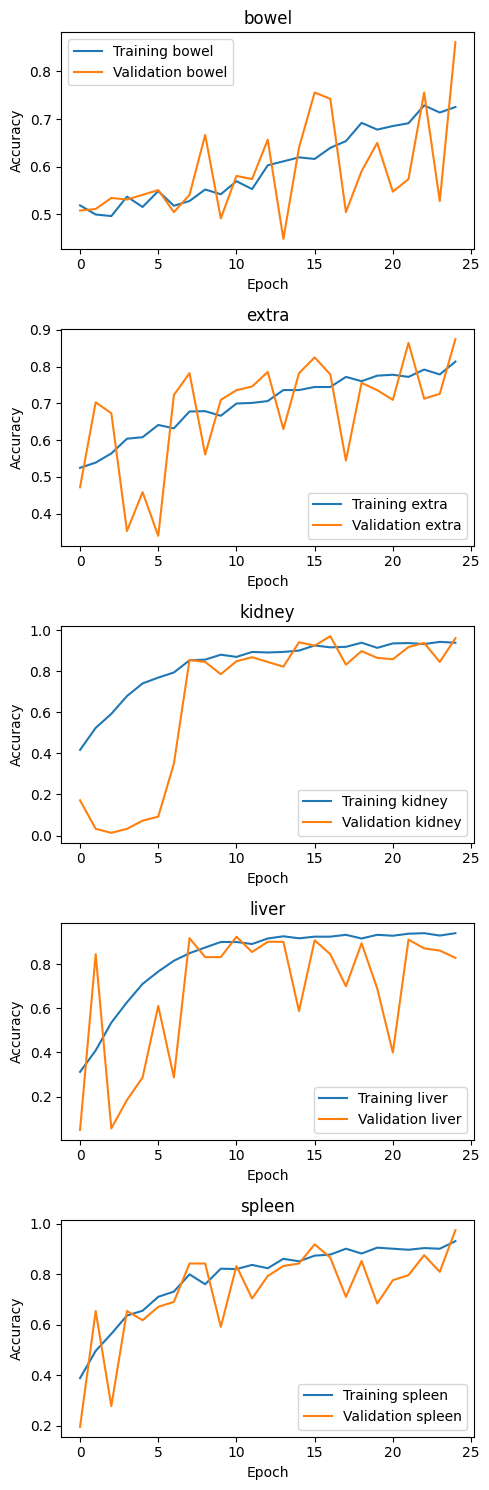

In [36]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

Plot the validation loss vs training loss

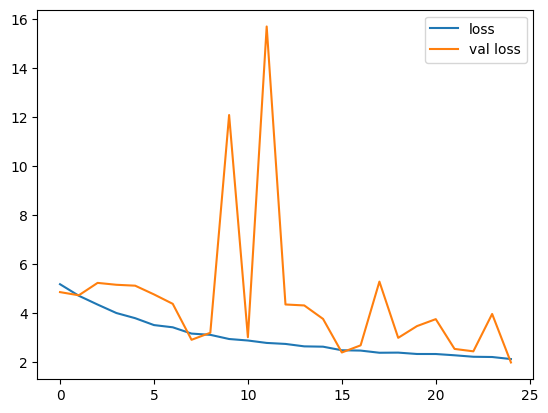

In [37]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [38]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 1.996
>>>> BEST Acc   : 0.900
>>>> BEST Epoch : 24

ORGAN Acc:
  >>>> Bowel           : 0.861
  >>>> Extravasation   : 0.875
  >>>> Liver           : 0.828
  >>>> Kidney          : 0.960
  >>>> Spleen          : 0.974


## Store the model for inference

In [39]:
# Save the model
model.save("rsna-atd.keras")

In [40]:
MODEL_PATH = "/kaggle/working/rsna-atd.keras"
model = tf.keras.models.load_model(MODEL_PATH)

In [41]:
# Save the model to S3
s3resource=boto3.client('s3','ap-southeast-2')
s3resource.upload_file("/kaggle/working/rsna-atd.keras","rsna-kaggle-2023","rsna-atd.keras")

NoCredentialsError: Unable to locate credentials

# Next Steps

1. Please refer to the [Inference Notebook](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer) to learn about submitting to the competition
2. Dive deep into [KerasCV](https://github.com/keras-team/keras-cv) and [KerasCore](https://github.com/keras-team/keras-core)

# Credits

This notebook was forked from https://www.kaggle.com/code/awsaf49/rsna-atd-cnn-tpu-train

In [ ]:
MODEL_PATH = "/kaggle/working/rsna-atd.keras"
model = tf.keras.models.load_model(MODEL_PATH)